In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler, RobustScaler
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
#from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import NearMiss
# from imblearn.metrics import classification_report_imbalanced
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.svm import OneClassSVM 

import warnings
warnings.filterwarnings("ignore")


In [24]:
path="/Library/Java/JavaVirtualMachines/Arsal/Dropbox/creditcard.csv"
df = pd.read_csv(path)

In [3]:
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

"This shows that the dataset is highly imbalanced"

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


'This shows that the dataset is highly imbalanced'

(0.0, 172792.0)

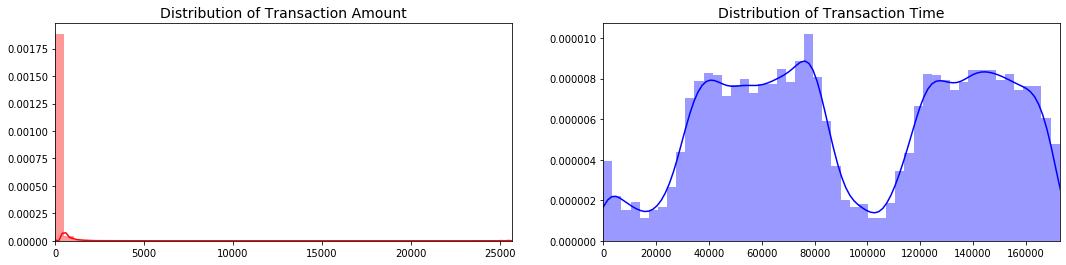

In [4]:
"Distribution of Features to check if they are skewed"
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values
# V1_val = df["V1"].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

# sns.distplot(V1_val, ax=ax[2], color='g')
# ax[2].set_title('Distribution of V1', fontsize=14)
# ax[2].set_xlim([min(V1_val), max(time_val)])

In [5]:
"""Scaling
1) We see that the Time and Amount are not scaled to other variables in the dataset
2) create a balanced dataset 
"""
std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df["scaled_amount"]=rob_scaler.fit_transform(df["Amount"].values.reshape(-1,1))
df["scaled_time"]=rob_scaler.fit_transform(df["Time"].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)


In [6]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.269825,-0.994983
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.983721,-0.994972
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.418291,-0.994972
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.670579,-0.994960


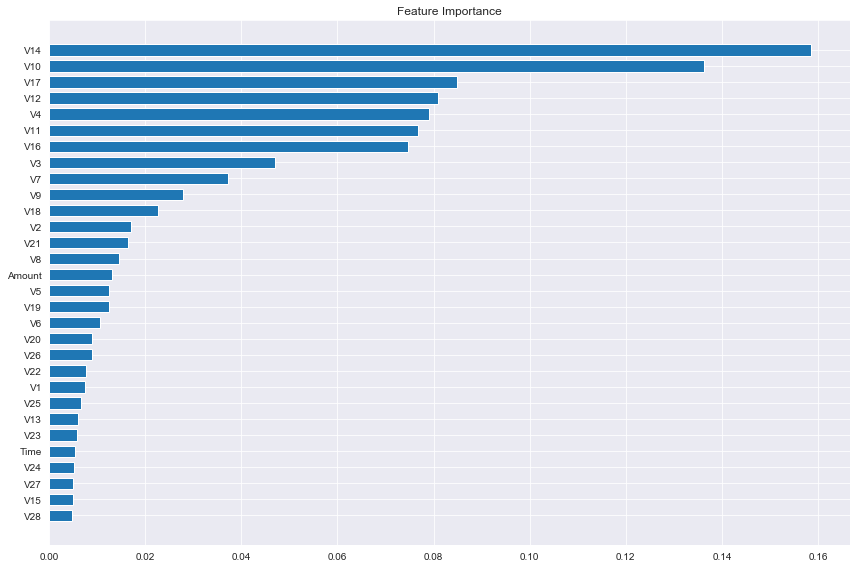

In [26]:
from sklearn.model_selection import train_test_split

df1 = df.sample(frac=1)
fraud = df1[df1.Class ==1]
non_fraud = df1[df1.Class==0][:492]
new_df = pd.concat([fraud, non_fraud])
new_df =new_df.sample(frac=1)

x=new_df.drop(["Class"],axis = 1)
y = new_df["Class"]

x_train,x_test, y_train, y_test = train_test_split(x,y,test_size = 0.33, random_state =42)
model = RandomForestClassifier()
model.fit(x_train, y_train)

importance = model.feature_importances_
importance_sort_idx = np.argsort(importance)
tree_indices = np.arange(0, len(importance)) + 0.5

"""Plot Feature importance"""
fig, (ax1) = plt.subplots(1,1,figsize=(12, 8))
ax1.barh(tree_indices,
         importance[importance_sort_idx], height=0.7)

ax1.set_yticklabels(x_train.columns[importance_sort_idx])
ax1.set_yticks(tree_indices)
#ax1.set_ylim((0, len(clf.feature_importances_)))
ax1.set_title("Feature Importance")
fig.tight_layout()


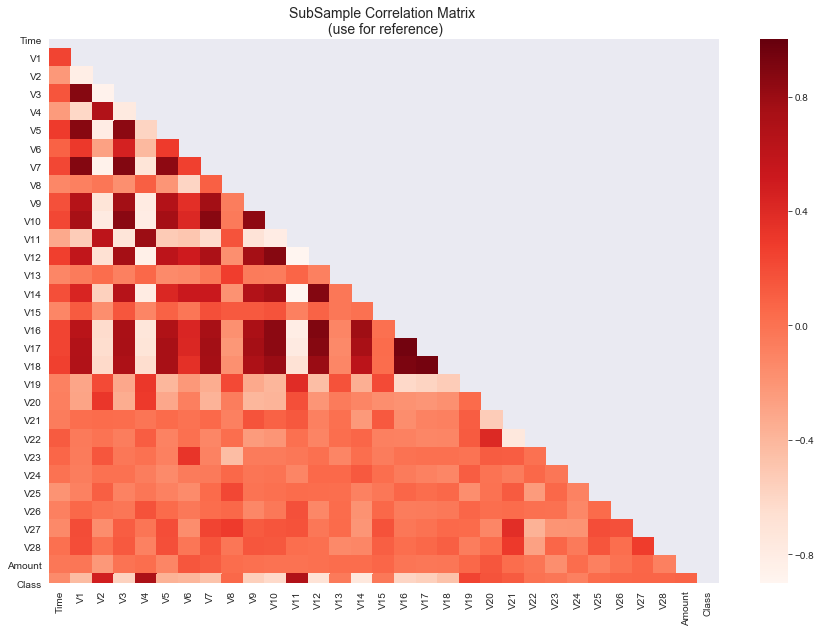

In [27]:
f, ax1 = plt.subplots(1, 1, figsize=(15,10))


sub_sample_corr = new_df.corr()
mask_ut=np.triu(np.ones(sub_sample_corr.shape)).astype(np.bool)
sns.heatmap(sub_sample_corr, mask = mask_ut,cmap='Reds', annot_kws={'size':20}, ax=ax1)

ax1.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

Text(0.5, 1.0, 'V14 vs Class Negative Correlation')

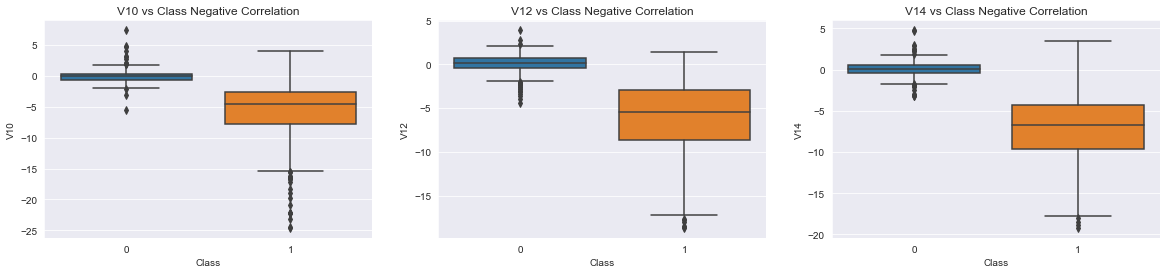

In [28]:
f, axes = plt.subplots(ncols=3, figsize=(20,4))
sns.boxplot(x="Class", y="V10", data=new_df, ax=axes[0])
axes[0].set_title('V10 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V12", data=new_df, ax=axes[1])
axes[1].set_title('V12 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=new_df, ax=axes[2])
axes[2].set_title('V14 vs Class Negative Correlation')


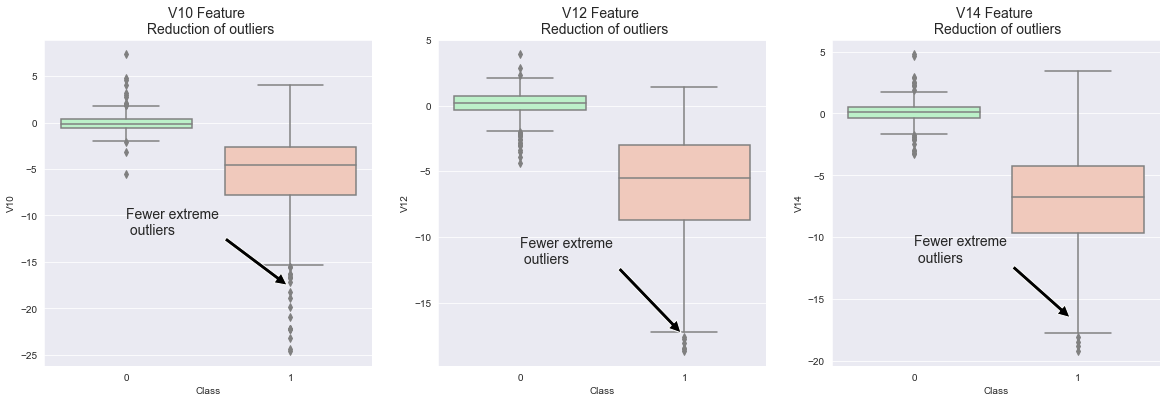

In [29]:
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))

colors = ['#B3F9C5', '#f9c5b3']
# Boxplots with outliers removed
# Feature V10
sns.boxplot(x="Class", y="V10", data=new_df,ax=ax1, palette=colors)
ax1.set_title("V10 Feature \n Reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature 12
sns.boxplot(x="Class", y="V12", data=new_df, ax=ax2, palette=colors)
ax2.set_title("V12 Feature \n Reduction of outliers", fontsize=14)
ax2.annotate('Fewer extreme \n outliers', xy=(0.98, -17.3), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature V14
sns.boxplot(x="Class", y="V14", data=new_df, ax=ax3, palette=colors)
ax3.set_title("V14 Feature \n Reduction of outliers", fontsize=14)
ax3.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)


plt.show()

Text(0.5, 1.0, 't-SNE visualization of data')

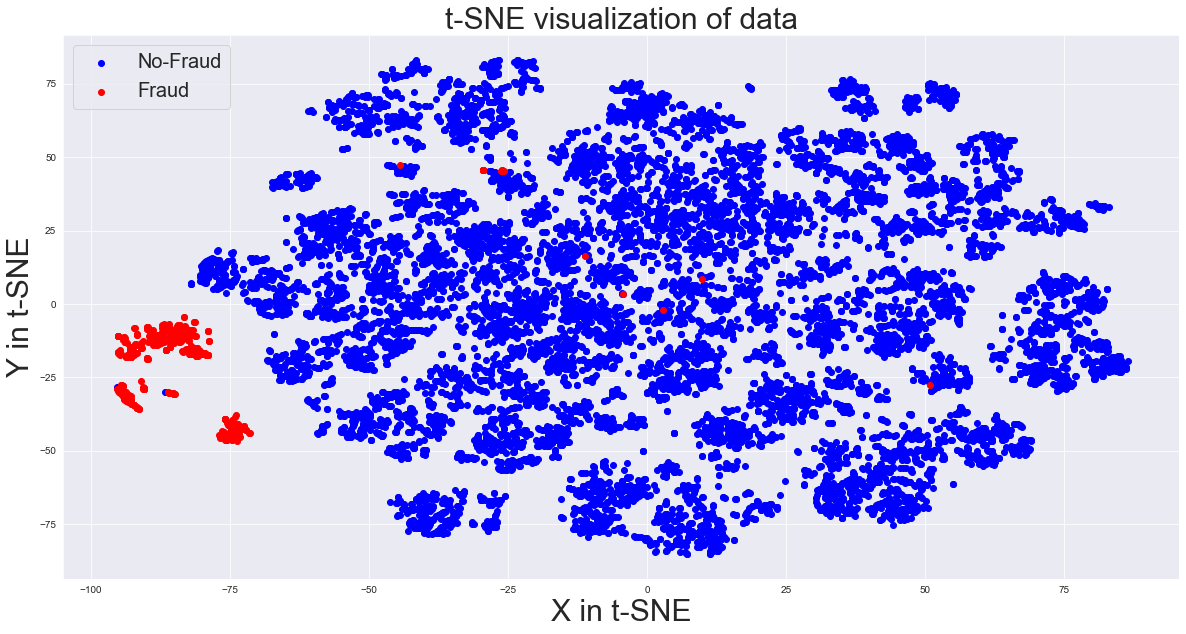

In [30]:
tsne_data = df
df2 = tsne_data[tsne_data.Class == 1]
df2 = pd.concat([df2, tsne_data[tsne_data.Class == 0].sample(n = 15000)], axis = 0)
#Scale features to improve the training ability of TSNE.
standard_scaler = StandardScaler()
df2_std = standard_scaler.fit_transform(df2)

#Set y equal to the target values.
y = df2.iloc[:,-1].values

tsne = TSNE(n_components=2, random_state=0)
x_test_2d = tsne.fit_transform(df2_std)

normal = x_test_2d[y==0]
fraud = x_test_2d[y==1]


# color_map = {0:'blue', 1:'red'}
plt.figure(figsize = (20,10))
sns.set_style("darkgrid")

plt.scatter(normal[:,0], normal[:,1],c='blue',label = "No-Fraud")
plt.scatter(fraud[:,0],fraud[:,1],c='red', label = "Fraud")    
plt.xlabel('X in t-SNE',fontsize= 30)
plt.ylabel('Y in t-SNE', fontsize = 30)
plt.legend(loc='upper left')
plt.legend(loc=2, prop={'size': 20})

plt.title('t-SNE visualization of data', fontsize = 30)

# plt.show()


In [31]:
df2_new=df2.drop(['Time','Amount'], axis=1)
train, test = train_test_split(df2_new, test_size=.2) 
test1 = test.iloc[:,:-1]

train_normal = train[train['Class']==0] 
train_normal = train_normal.iloc[:,:-1]
train_outliers = train[train['Class']==1] 
train_outliers = train_outliers.iloc[:,:-1]
outlier_prop = len(train_outliers) / len(train_normal) 
outlier_prop

svm = OneClassSVM(kernel='rbf', nu=outlier_prop, gamma=0.000001) 
svm.fit(train_normal)



OneClassSVM(gamma=1e-06, nu=0.033352789126990745)

(-5, 5)

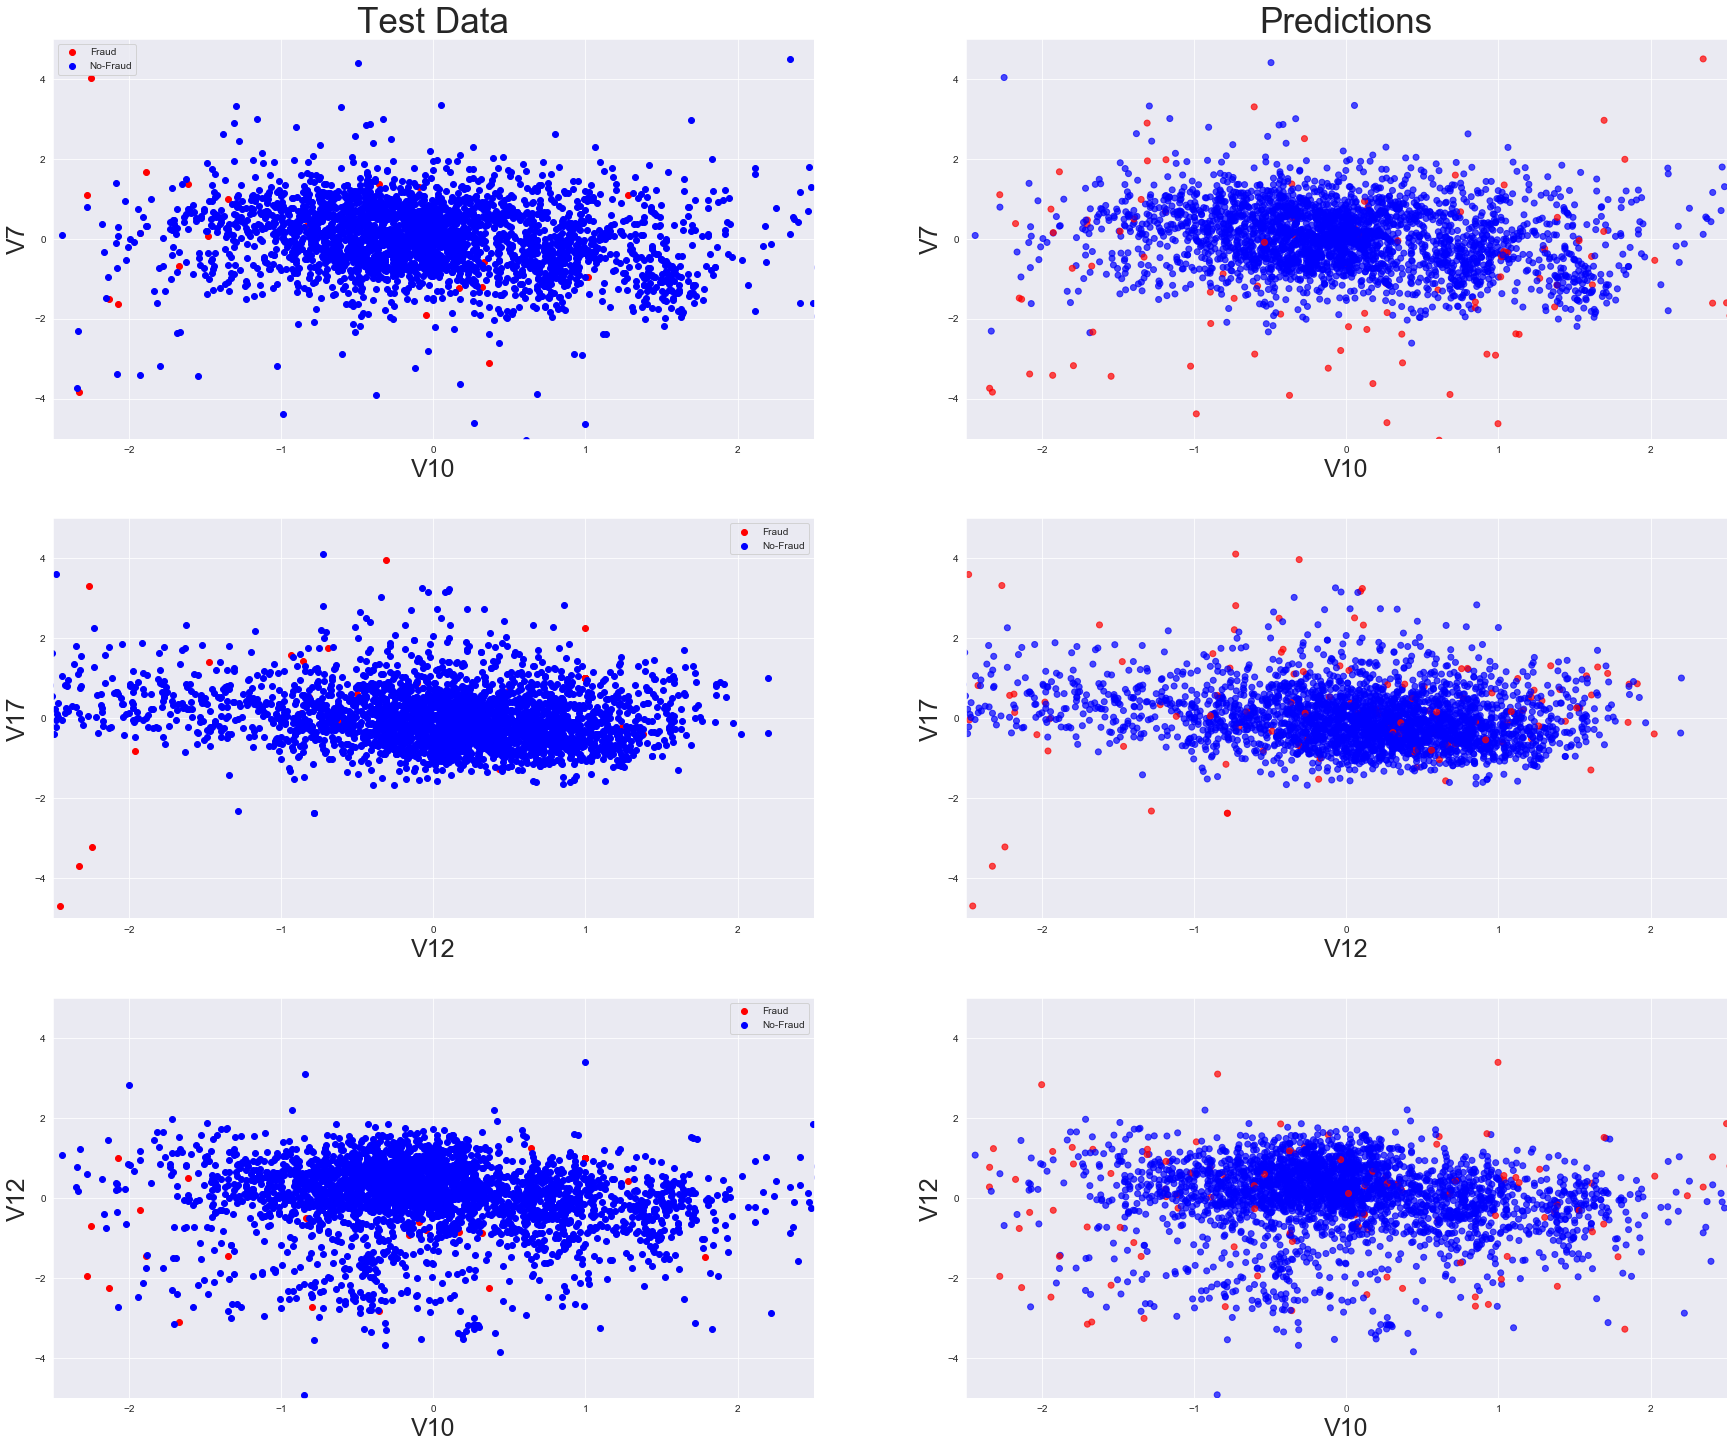

In [32]:
fig, ax = plt.subplots(3,2, figsize=(30,25))
#x = test['V10'] 
x = test[['V10','Class']]
x_normal = x[x['Class']==0]
x_anom = x[x['Class']==1]

# y = test['V7']
y = test[['V7','Class']]
y_normal = y[y['Class']==0]
y_anom = y[y['Class']==1]
ax[0][0].scatter(x_anom, y_anom,c='red',label='Fraud') 
ax[0][0].scatter(x_normal, y_normal,c='blue',label = 'No-Fraud')
ax[0][0].set_title('Test Data', fontsize = 35)
ax[0][0].legend()
ax[0][0].set_xlim([-2.5,2.5])
ax[0][0].set_ylim([-5,5])

x = test1['V10'] 
y = test1['V7'] 
y_pred = svm.predict(test1) 
colors = np.array(['#ff0000', '#0000FF']) 
ax[0][1].scatter(x, y, alpha=0.7, c=colors[(y_pred + 1) // 2]) 
ax[0][1].set_title('Predictions', fontsize = 35)
ax[0][1].set_xlabel('V10', fontsize = 25)
ax[0][1].set_ylabel('V7', fontsize = 25)
ax[0][0].set_xlabel('V10', fontsize = 25)
ax[0][0].set_ylabel('V7', fontsize = 25)
ax[0][1].set_xlim([-2.5,2.5])
ax[0][1].set_ylim([-5,5])

####################################################
x12 = test[['V12','Class']]
x_normal12 = x12[x12['Class']==0]
x_anom12 = x12[x12['Class']==1]
y17 = test[['V17','Class']]
y_normal17 = y17[y17['Class']==0]
y_anom17 = y17[y17['Class']==1]
ax[1][0].scatter(x_anom12, y_anom17,c='red',label='Fraud') 
ax[1][0].scatter(x_normal12, y_normal17,c='blue',label = 'No-Fraud')
ax[1][0].set_xlabel('V12', fontsize = 25)
ax[1][0].set_ylabel('V17', fontsize = 25)
ax[1][0].legend()
ax[1][0].set_xlim([-2.5,2.5])
ax[1][0].set_ylim([-5,5])

"""Predictions"""
x = test1['V12'] 
y = test1['V17'] 
y_pred = svm.predict(test1) 
colors = np.array(['#ff0000', '#0000FF']) 
ax[1][1].scatter(x, y, alpha=0.7, c=colors[(y_pred + 1) // 2]) 
ax[1][1].set_xlabel('V12', fontsize = 25)
ax[1][1].set_ylabel('V17', fontsize = 25)
ax[1][1].set_xlim([-2.5,2.5])
ax[1][1].set_ylim([-5,5])



####################################################
x10 = test[['V10','Class']]
x_normal10 = x10[x10['Class']==0]
x_anom10 = x10[x10['Class']==1]
y11 = test[['V12','Class']]
y_normal11 = y11[y11['Class']==0]
y_anom11 = y11[y11['Class']==1]
ax[2][0].scatter(x_anom10, y_anom11,c='red',label='Fraud') 
ax[2][0].scatter(x_normal10, y_normal11, c='blue',label = 'No-Fraud')
ax[2][0].set_xlabel('V10', fontsize = 25)
ax[2][0].set_ylabel('V12', fontsize = 25)
ax[2][0].legend()
ax[2][0].set_xlim([-2.5,2.5])
ax[2][0].set_ylim([-5,5])


x = test1['V10'] 
y = test1['V12'] 
y_pred = svm.predict(test1) 
colors = np.array(['#ff0000', '#0000FF']) 
ax[2][1].scatter(x, y, alpha=0.7, c=colors[(y_pred + 1) // 2]) 
ax[2][1].set_xlabel('V10', fontsize = 25)
ax[2][1].set_ylabel('V12', fontsize = 25)
ax[2][1].set_xlim([-2.5,2.5])
ax[2][1].set_ylim([-5,5])

# plt.savefig("predictions")